# Sample Selection

Select a sample of 8 halos from the halo catalog.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

In [2]:
BOX_SIZE = 58480
HUBBLE_CONSTANT = 0.68
M_MAX = 10**12.2
M_MIN = 10**11.8
R_ISO = 3
RANDOM_SEED = 42

## Read Halo Catalog

In [3]:
def read_ahf_halos(path):
    names = []
    with open(path) as f:
        for line in f:
            if line.startswith('#ID'):
                names += line.strip('#').strip().split('\t')
                # Remove the trailing '()' component in column names
                names = [name[:name.find('(')] for name in names]
                break
    df = pd.read_csv(path, comment='#', delim_whitespace=True, header=None,
                     names=names)
    return df

hc = read_ahf_halos('../config/halo-sample/ahf/snapshot_005.AHF_halos')

# Convert mass unit from Msun/h to Msun
hc['Mvir'] /= HUBBLE_CONSTANT

len(hc)

393455

## Select Candidates

Select candidate halos from the halo catalog. A candidate halo satisfy the following criteria:

- It is within the desired virial mass range.
- It is a host halo.
- It is an isolated halo.

Select massive host halos.

In [4]:
# Select host halos
massive = hc[hc['hostHalo'] == 0]

# Restrict minimum halo mass
massive = massive[massive['Mvir'] > M_MIN]

# Save results
massive = massive[['Mvir', 'Rvir', 'Xc', 'Yc', 'Zc']]
massive.sort_values(by='Mvir', ascending=False, inplace=True)
massive.to_csv('../config/halo-sample/massive.csv', index=False)
massive = pd.read_csv('../config/halo-sample/massive.csv')
len(massive)

1179

Mark isolated halos and save all host halos within the mass range.

In [5]:
from scipy.spatial import cKDTree

host = massive.copy()

# Mark isolated halos
host.reset_index(drop=True, inplace=True)
host['isolated'] = True
tree = cKDTree(host[['Xc', 'Yc', 'Zc']].values, boxsize=BOX_SIZE)
for i, row in host.iterrows():
    neighbors = tree.query_ball_point(row[['Xc', 'Yc', 'Zc']].values, row['Rvir'] * R_ISO)
    neighbors.remove(i)
    for j in neighbors:
        if row['Mvir'] > host['Mvir'][j]:
            host.loc[j, 'isolated'] = False
        else:
            host.loc[i, 'isolated'] = False

# Restrict maximum halo mass
host = host[host['Mvir'] < M_MAX]

# Append local environment density information
host.reset_index(drop=True, inplace=True)
host['Menv'] = pd.read_csv('../config/halo-sample/env-dens.csv')['Menv']

# Save results
host = host[['Mvir', 'Menv', 'Rvir', 'Xc', 'Yc', 'Zc', 'isolated']]
host.sort_values(by='Mvir', ascending=False, inplace=True)
host.to_csv('../config/halo-sample/host.csv', index=False)
host = pd.read_csv('../config/halo-sample/host.csv')
print('host:', len(host))
print('isolated:', host['isolated'].sum())
print('isolated/host:', host['isolated'].sum() / len(host))

host: 823
isolated: 682
isolated/host: 0.8286755771567437


## Select Sample

In [6]:
isolated = host[host['isolated']]

Select sample.

In [7]:
x = np.log10(isolated['Mvir'].values)
y = np.log10(isolated['Menv'].values)
x_min, x_max = np.log10(M_MIN), np.log10(M_MAX)
i, xbins = pd.cut(x, np.linspace(x_min, x_max, 3), labels=False, retbins=True)
j, ybins = pd.qcut(y, 4, labels=False, retbins=True)
isolated = isolated.assign(i=i)
isolated = isolated.assign(j=j)
sample = isolated.groupby(['i', 'j']).apply(
    lambda df: df.sample(random_state=RANDOM_SEED)
)
label = []
for i, j in zip(sample['i'], sample['j']):
    label += [f'h{i}{j}']
sample['label'] = label
sample = sample[['label', 'Mvir', 'Menv', 'Rvir', 'Xc', 'Yc', 'Zc']]
sample.to_csv('../config/halo-sample/sample.csv', index=False)
sample = pd.read_csv('../config/halo-sample/sample.csv')
sample

,label,Mvir,Menv,Rvir,Xc,Yc,Zc
0,h00,7.979132e+11,2.819314e+13,201.47,49170.089337,33786.476668,52855.808780
1,h01,6.993882e+11,3.473914e+13,192.81,13666.768048,28546.056699,17039.167883
2,h02,7.363382e+11,5.433447e+13,196.17,50807.038260,26875.987772,411.452731
3,h03,7.888647e+11,7.143640e+13,200.79,20526.445390,53408.016776,34614.400459
4,h10,1.360907e+12,2.450638e+13,240.72,39945.983562,38147.402526,24420.498039
5,h11,1.548412e+12,3.884653e+13,251.31,27793.783467,56125.782908,29987.371643
6,h12,1.528618e+12,4.885592e+13,250.23,22767.696737,48431.641735,27004.873023
7,h13,1.542176e+12,1.025698e+14,250.96,51660.697035,14354.821082,24055.037640


Plot sample selection.

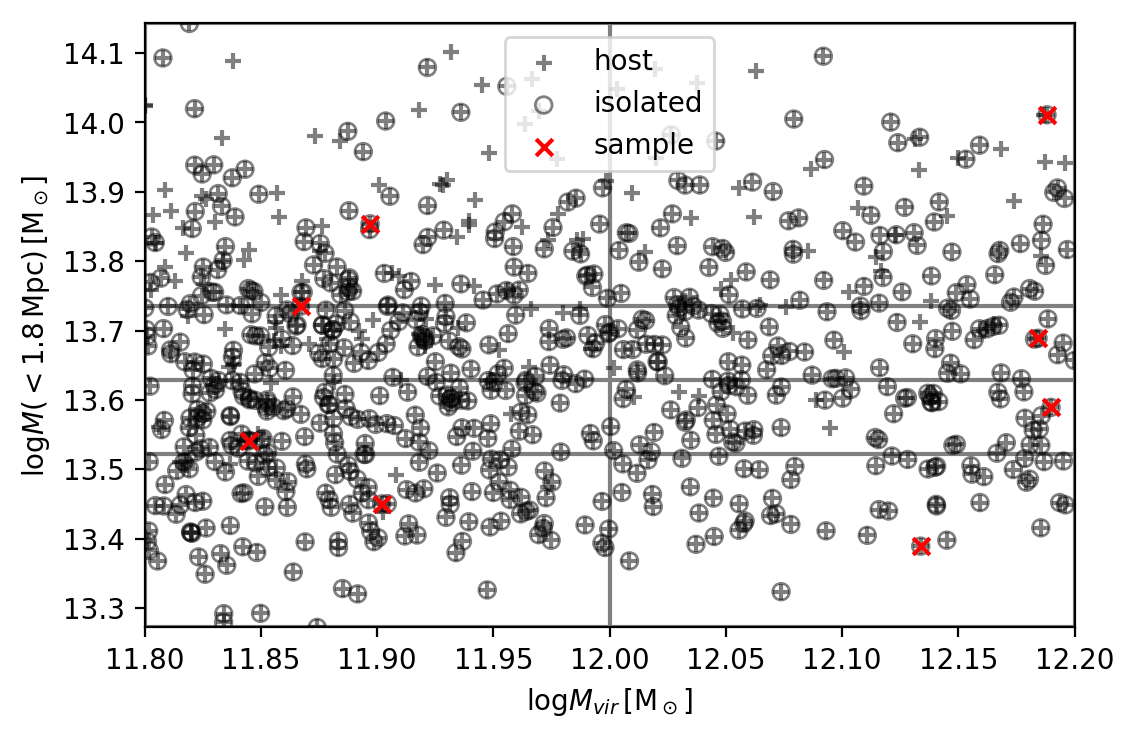

In [8]:
plt.figure(dpi=200)
plt.scatter(np.log10(host['Mvir']), np.log10(host['Menv']), label='host',
            marker='+', color='k', alpha=0.5, zorder=1)
plt.scatter(np.log10(isolated['Mvir']), np.log10(isolated['Menv']), label='isolated',
            marker='o', facecolors='none', edgecolors='k', alpha=0.5, zorder=2)
plt.scatter(np.log10(sample['Mvir']), np.log10(sample['Menv']), label='sample',
            marker='x', color='r', zorder=3)
xlim = xbins[[0, -1]]
ylim = ybins[[0, -1]]
plt.vlines(xbins, *ylim, color='grey', zorder=0)
plt.hlines(ybins, *xlim, color='grey', zorder=0)
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.xlabel('$\log{M_{vir}}\,\mathrm{[M_\odot]}$')
plt.ylabel('$\log{M(<1.8\,\mathrm{Mpc})}\,\mathrm{[M_\odot]}$')
plt.legend()
plt.show()

Show sample halo positions. Each halo is represented by a sphere with $4\,R_{vir}$ radius.

In [9]:
import ipyvolume as ipv

ipv.quickscatter(sample['Xc'], sample['Yc'], sample['Zc'],
                 size=100*4*sample['Rvir']/BOX_SIZE, marker='sphere')
ipv.xyzlim(0, BOX_SIZE)
ipv.show()

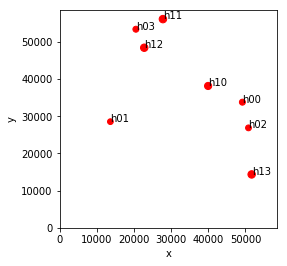

In [10]:
fig, ax = plt.subplots()
for i, row in sample.iterrows():
    ax.add_artist(plt.Circle(row[['Xc', 'Yc']], 4*row['Rvir'], color='r'))
    ax.annotate(row['label'], xy=row[['Xc', 'Yc']])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(0, BOX_SIZE)
ax.set_ylim(0, BOX_SIZE)
ax.set_aspect('equal')
plt.show()